# OpenET GEESEBAL
## Image Class Property/Method Example
This example shows how to instantiate the model Image class for a single Landsat image using the ".from_landsat_c1_sr()" helper method.  This example also shows how to get the model variables.

## Setup

In [1]:
import pprint
import sys
import ee
from IPython.display import Image

sys.path.append(r'C:\openet_brazil\openet-geesebal')

import openet.geesebal as model

### Initialize Earth Engine

In [2]:
# Initialize the Earth Engine package, initiating the authentication flow if needed.
try:
    ee.Initialize(project='et-brasil')
except ee.EEException:
    ee.Authenticate()
    ee.Initialize(project='et-brasil')

## Analysis

In [3]:
ndvi_palette = [
    '#0010FF','#1020FF','#2030FF','#3040FF','#4050FF','#5060FF','#6070FF',
    '#7080FF','#8090FF','#90A0FF','#A0B0FF','#B0C0FF','#C0D0FF','#D0E0FF',
    '#E0F0FF','#F0FFFF',
    'ffffff',
    'ce7e45', 'df923d', 'f1b555', 'fcd163', '99b718', '74a901',
    '66a000', '529400', '3e8601', '207401', '056201', '004c00', '023b01',
    '012e01', '011d01', '011301']
et_palette = [
    'DEC29B', 'E6CDA1', 'EDD9A6', 'F5E4A9', 'FFF4AD', 'C3E683', '6BCC5C', 
    '3BB369', '20998F', '1C8691', '16678A', '114982', '0B2C7A']
viridis_palette = ['440154', '433982', '30678D', '218F8B', '36B677', '8ED542', 'FDE725']
temp_palette = ['#380061','#2222ab','#5676d6','#83a3da','#dfdbb3','#da8c83','#d35454','#b02323','#4d0f0f']

image_size = 768

### Landsat 8 Collection 1 SR Image

In [8]:

landsat_img = ee.Image('LANDSAT/LT05/C02/T1_L2/LT05_223067_20040531')
landsat_crs = landsat_img.select('SR_B3').projection().getInfo()['crs']
landsat_region = landsat_img.geometry().bounds(1, 'EPSG:4326')
landsat_dt = ee.Date(landsat_img.get('system:time_start'))

landsat_img = ee.Image("LANDSAT/LC08/C02/T1_L2/LC08_231067_20150911")
landsat_img = ee.Image('LANDSAT/LT05/C02/T1_L2/LT05_223067_20040531')

landsat_region = landsat_img.geometry().bounds(1, 'EPSG:4326')

#landsat_region_sm = ee.Geometry.Polygon(
#        [[-62.355831545156235, -9.890931711122295],
#          [-62.355831545156235, -10.690834912172688],
#          [-61.504391115468735, -10.690834912172688],
#          [-61.504391115468735, -9.890931711122295]])
landsat_crs = landsat_img.select('SR_B3').projection().getInfo()['crs']


# print(landsat_img.get('system:time_start').getInfo())

In [5]:
# image_url = landsat_img.select(['B4', 'B3', 'B2'])\
#     .multiply([0.0001, 0.0001, 0.0001])\
#     .getThumbURL({'min': 0.0, 'max': 0.3, 
#                   'region': landsat_region, 'dimensions': image_size})
# Image(image_url, embed=True, format='png')

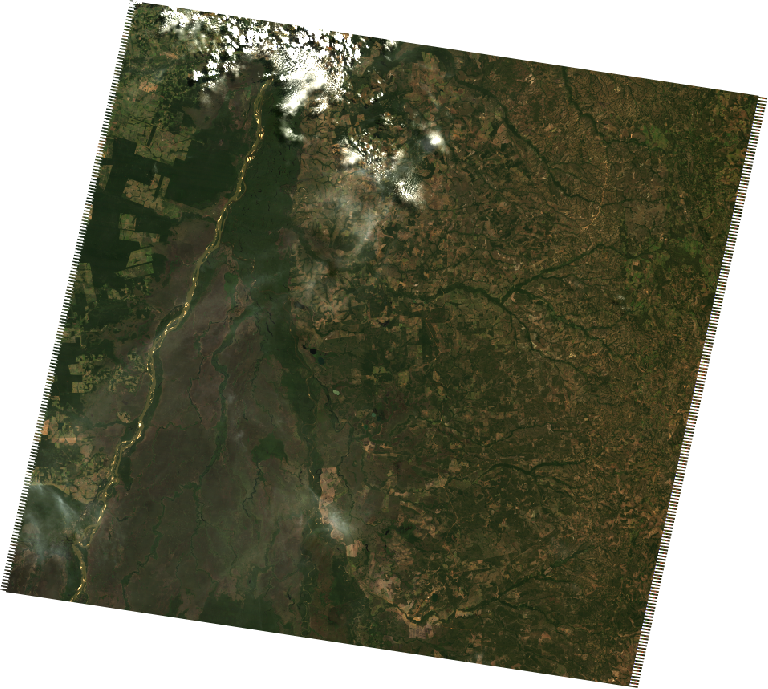

In [9]:
# Uncomment for Collection 2
image_url = landsat_img.select(['SR_B3', 'SR_B2', 'SR_B1'])\
    .multiply([0.0000275, 0.0000275, 0.0000275])\
    .add([-0.2, -0.2, -0.2])\
    .getThumbURL({'min': 0.0, 'max': 0.23, 
                  'region': landsat_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

In [10]:
# Build the geeSEBAL object from the Landsat image
model_obj = model.Image.from_landsat_c2_sr(
    landsat_img,
     meteo_location='br',
     et_reference_source='projects/et-brasil/assets/ERA5/daily/DAILY_ETO', 
     et_reference_band='eto',
     et_reference_resample='bilinear',
    calibration_points=5
)

### NDVI

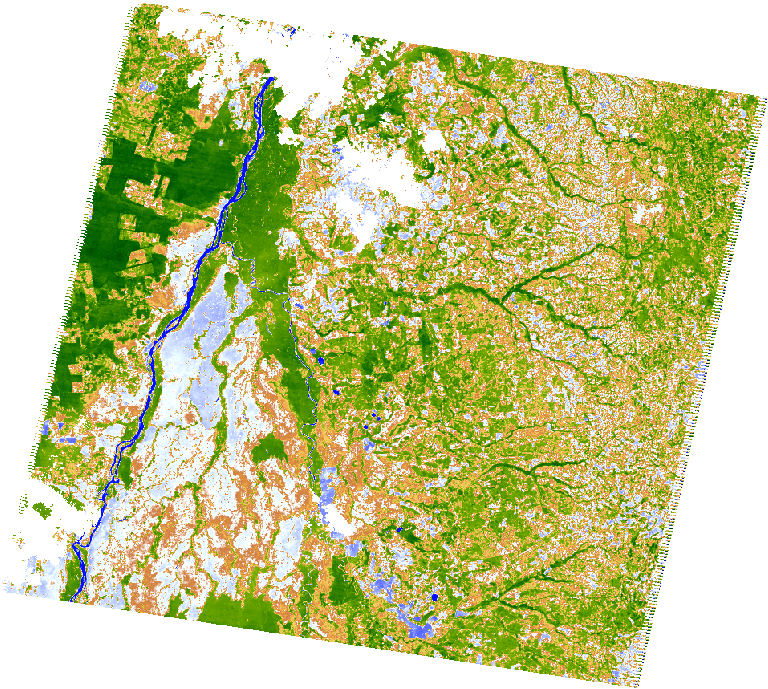

In [11]:
image_url = model_obj.ndvi\
    .getThumbURL({'min': 0, 'max': 1, 'palette': ndvi_palette, 
                  'region': landsat_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

### LST

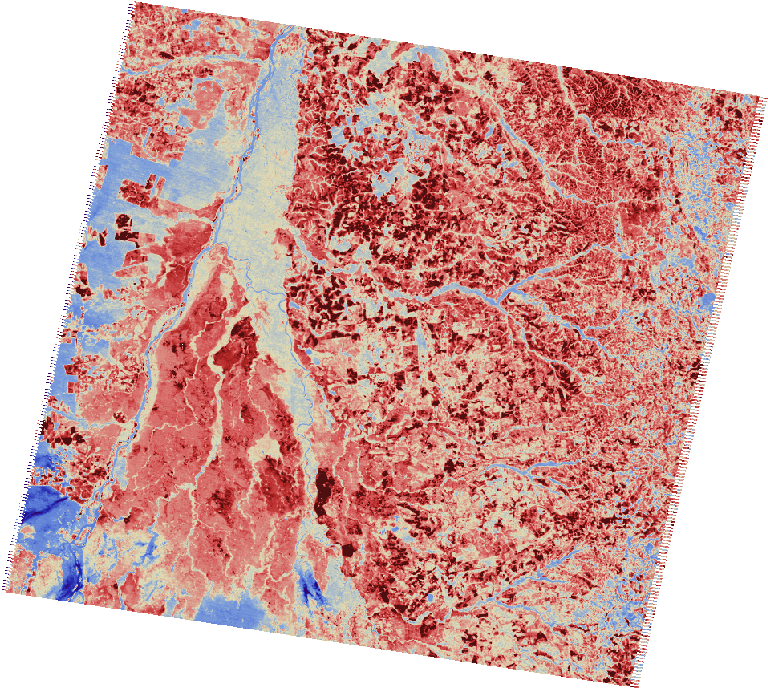

In [12]:
image_url = model_obj.lst\
    .getThumbURL({'min': 295.15, 'max': 310.15, 'palette':temp_palette, 
                  'region': landsat_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

### ET fraction

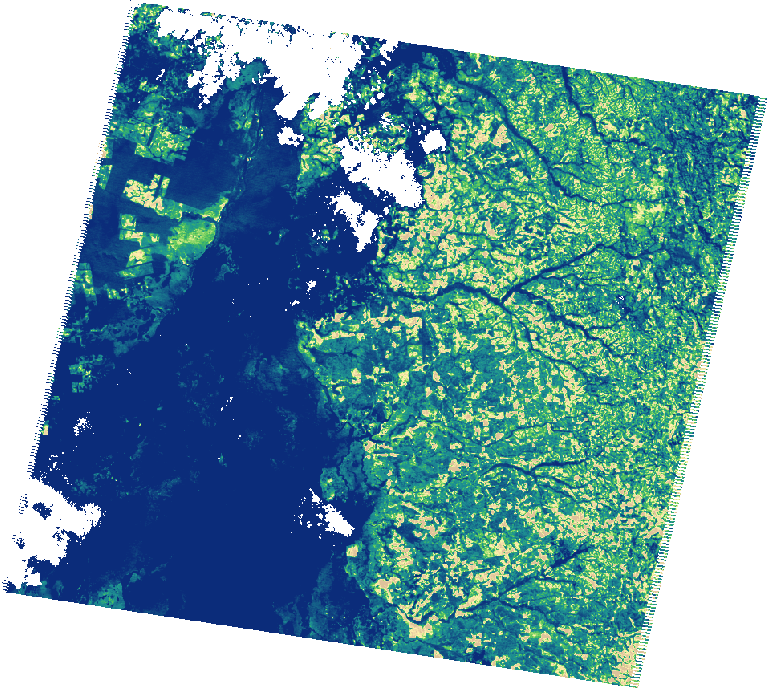

In [12]:
image_url = model_obj.et_fraction\
    .getThumbURL({'min': 0.0, 'max': 1, 'palette': et_palette, 
                  'region': landsat_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

### Reference ET

In [12]:
# # Clip and project to the Landsat image footprint and coordinate system
# image_url = model_obj.et_reference\
#     .getThumbURL({'min': 0.0, 'max': 12, 'palette': et_palette, 
#                   'region': landsat_region, 'dimensions': image_size})
# Image(image_url, embed=True, format='png')

### ET

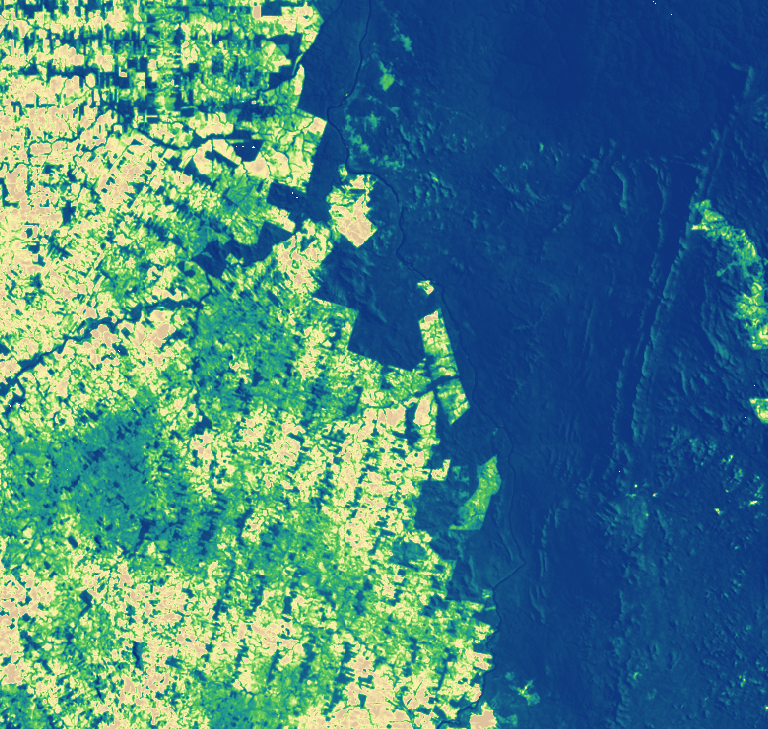

In [7]:
image_url = model_obj.et\
    .getThumbURL({'min': 0, 'max': 5, 'palette': et_palette, 
                  'region': landsat_region_sm, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

In [8]:
task = ee.batch.Export.image.toDrive(**{
    'image': model_obj.et,
    'description': 'geesebal_eecu_problems_simplified_etr',
    'folder':'openet_meeting',
    'scale': 30,
    'region': landsat_region_sm
})
task.start()